In [1]:
! pip install -q tensorflow-model-optimization
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from bs4 import BeautifulSoup
import cv2 as cv
from google.colab.patches import cv2_imshow as cv_imshow
from sklearn.model_selection import train_test_split
import random
from google.colab import drive
from tqdm import tqdm
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, BatchNormalization
from keras.models import Model
from keras import optimizers
from time import time

     |████████████████████████████████| 213 kB 5.3 MB/s 


<H1> Data Preparation

In [2]:
drive._mount("/content/drive/")

path = '/content/drive/MyDrive/hand-segmentation/'
mask_folder = 'skin_masks'
img_folder = 'original_images'

# get the paths for segmented masks
mask_paths = []
for name in glob(path + mask_folder + '/*.bmp'):
  mask_paths.append(name)

# get the paths for images of hands
hand_paths = []
for name in glob(path + img_folder + '/*.jpg'):
  hand_paths.append(name)

Mounted at /content/drive/


In [3]:
hand_paths.sort()
mask_paths.sort()

In [4]:
def get_file_name(file_path: str) -> str:
  name_ext = file_path.split('/')[-1]
  name = name_ext.split('.')[0]

  return name

mask_paths.pop(537)

for i in range(len(hand_paths)):
  mask_name = get_file_name(mask_paths[i])
  img_name = get_file_name(hand_paths[i])

  if mask_name != img_name:
    print(i, mask_name, img_name)
    break

In [5]:
# read the images and masks stored in the found paths

hand_images = []
for path in tqdm(hand_paths):
  image = cv.imread(path)

  # convert from BGR to HSV colorspace for easier classification later
  image = cv.cvtColor(image,cv.COLOR_BGR2HSV)
  hand_images.append(image)

hand_masks = []
for path in tqdm(mask_paths):
  mask = cv.imread(path)
  hand_masks.append(mask)

100%|██████████| 898/898 [03:45<00:00,  3.99it/s]


In [6]:
# convert the image and mask to float-arrays and normalise their values to be between 0 and 1

for i in tqdm(range(len(hand_images))):
  hand_images[i] = hand_images[i].astype('float32') / 255
  hand_masks[i] = hand_masks[i].astype('float32') / 255

100%|██████████| 898/898 [00:02<00:00, 338.19it/s]


In [7]:
# Resize all images to a standard size to make the data more appropriate for a CNN architecture

res_images = []
res_masks = []

new_size = (128, 128)

for i in range(len(hand_images)):

  res_images.append(cv.resize(hand_images[i], new_size))

  res_masks.append(cv.resize(hand_masks[i], new_size))

In [8]:
del hand_images
del hand_masks

In [74]:
X = np.array(res_images)
y = np.array(res_masks)
y = y.sum(axis=3) / 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [75]:
from skimage.transform import rotate

X_train_rot = []
y_train_rot = []

for i in tqdm(range(len(X_train))):
  theta = random.randint(0, 359)

  X_train_rot.append(rotate(X_train[i], angle=theta))
  y_train_rot.append(rotate(y_train[i], angle=theta))

X_train_rot = np.array(X_train_rot)
y_train_rot = np.array(y_train_rot)

100%|██████████| 601/601 [00:01<00:00, 367.44it/s]


In [76]:
X_train = np.concatenate([X_train, X_train_rot])
y_train = np.concatenate([y_train, y_train_rot])

In [77]:
del X_train_rot
del y_train_rot

In [78]:
# Set up hyperparameters

batch_size = 32
epochs = 15
inChannel = 3
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))

def unet(input_img):

  # First block Going down
  d1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  d1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(d1_2)

  # Second block Going down
  d2_1 = MaxPooling2D()(d1_3)
  d2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2_1)
  d2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2_2)

  # Third block Going down
  d3_1 = MaxPooling2D()(d2_3)
  d3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(d3_1)
  d3_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(d3_2)

  # Fourth block Going down
  d4_1 = MaxPooling2D()(d3_3)
  d4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4_1)
  d4_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4_2)

  # Fifth block 
  d5_1 = MaxPooling2D()(d4_3)
  d5_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d5_1)
  d5_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d5_2)

  # Fourth block going up, concatenated with Fourth block going down
  up4_0 = UpSampling2D((2, 2))(d5_3)
  up4_1 = tf.keras.layers.concatenate([d4_3, up4_0])
  up4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4_1)
  up4_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4_2)

  # Third block going up, concatenated with Third block going down
  up3_0 = UpSampling2D((2, 2))(up4_3)
  up3_1 = tf.keras.layers.concatenate([d3_3, up3_0])
  up3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3_1)
  up3_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3_2)

  # Second block going up, concatenated with Second block going down
  up2_0 = UpSampling2D((2, 2))(up3_3)
  up2_1 = tf.keras.layers.concatenate([d2_3, up2_0])
  up2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2_1)
  up2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2_2)

  # First block going up, concatenated with First block going down
  up1_0 = UpSampling2D((2, 2))(up2_3)
  up1_1 = tf.keras.layers.concatenate([d1_3, up1_0])
  up1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1_1)
  up1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1_2)

  # Output
  out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up1_3)

  return out

In [79]:
unet = Model(input_img, unet(input_img))
unet.compile(loss='mean_squared_error', optimizer = optimizers.rmsprop_v2.RMSprop())
unet.load_weights('/content/drive/MyDrive/hand-segmentation/unet.h5')

In [81]:
def apply_quantization_to_model(layer):
  if not isinstance(layer, tf.keras.layers.Concatenate):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
annotated_model = tf.keras.models.clone_model(
    unet,
    clone_function=apply_quantization_to_model,
)

# Now that the Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
q_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

In [86]:
q_aware_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [87]:
q_aware_model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/15
38/38 [==============================] - 66s 565ms/step - loss: 0.0068 - accuracy: 0.9690
Epoch 2/15
38/38 [==============================] - 19s 512ms/step - loss: 0.0055 - accuracy: 0.9704
Epoch 3/15
38/38 [==============================] - 19s 513ms/step - loss: 0.0053 - accuracy: 0.9706
Epoch 4/15
38/38 [==============================] - 20s 513ms/step - loss: 0.0046 - accuracy: 0.9714
Epoch 5/15
38/38 [==============================] - 20s 514ms/step - loss: 0.0041 - accuracy: 0.9720
Epoch 6/15
38/38 [==============================] - 20s 514ms/step - loss: 0.0038 - accuracy: 0.9723
Epoch 7/15
38/38 [==============================] - 20s 514ms/step - loss: 0.0036 - accuracy: 0.9725
Epoch 8/15
38/38 [==============================] - 19s 513ms/step - loss: 0.0033 - accuracy: 0.9727
Epoch 9/15
38/38 [==============================] - 20s 514ms/step - loss: 0.0032 - accuracy: 0.9729
Epoch 10/15
38/38 [==============================] - 20s 516ms/step - loss: 0.0031 - accura

In [88]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpckxg4el2/assets


INFO:tensorflow:Assets written to: /tmp/tmpckxg4el2/assets


In [89]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)

In [103]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite_qaware_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], X_test[0].reshape((1, 128, 128, 3)))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

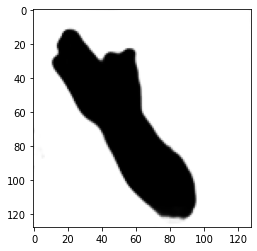

In [104]:
im = output_data.reshape(128, 128)
plt.imshow(im, cmap='gray')